<a href="https://colab.research.google.com/github/MatchLab-Imperial/deep-learning-course/blob/master/2020_06_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Networks Introduction

A Recurrent Neural Network (RNN) is a specific type of architecture that is widely used to deal with sequential information. So far, the introduced CNN architectures from the previous tutorials treated inputs as independent objects, however, many applications need to deal with data that is interconnected. For instance, if you are translating a sentence from English to Taiwanese, and you are predicting the next word, it is useful to know which words came before the last one.

RNNs are called recurrent since they apply the same operation to each of the input sequences, with the output of an individual element being dependent on the previous one. Theoretically, RNNs establish a connection between the actual input and ALL the previous ones. Although this is assumed, in the practice, RNNs have proven to only *remember* a limited number of inputs. In other words, RNNs have a *memory* that allows them to *remember* previous elements and use their information to deal with the current input. 

RNNs can be split into multiple types depending on their applications. For instance, if we want to predict one word given only the previous one, the topology of our network is a *One to One*. Another examples is image captioning,where we can design an *One to Many* architecture to obtain a description from a single input image. The following diagram shows the different types of problems we can face ([Source](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)):


![alt text](https://i.ibb.co/5hpYFzf/rnn-introduction.png)

**A Closer Look to RNN**

The figure below shows the simplest version of an RNN, which can be easily derived from a simple feedforward architecture by adding a single loop: 

![alt text](https://i.ibb.co/qnGH6RT/vanilla-rnn.png)

During training, the hidden state $h$ is iteratively updated based on the input value $x$ and the learned weights $W_h$ and $W_x$. The final output $y$ is estimated from the current state $h_t$ and the matrix $W_y$. 

Although RNN can assure short-term dependencies within the network, can they assure long-term dependencies? If RNNs could, it would be extremely useful. However, simple RNNs become unable to learn to connect information as the gap between past and present information grows. To overcome this limitation, in practical applications LSTM unit is adopted, that is a special RNNs architecture composed of multiple interacting layers ([Source](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)):
![alt text](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)



In this tutorial, we will use LSTMs straight away as a black box.

# ***Many to One* RNNs - Regression**

In this section, we are going to implement an easy example of an RNN in Keras. Given the records of a local newspaper, which indicates the number of new subscriptions per month, we want to predict the number of members that will join next month.

First, we load the data with the utility method in Pandas `read_csv`, which allows us to load directly the dataset from an URL address. Let's follow a good practice and print some rows of the imported record to see the format of the data.

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import io
import requests
data=pd.read_csv("https://drive.google.com/uc?id=1Hv2nuwVXO_aZN89llGva0hSH6k3kKAVm",usecols=[1],engine = "python")
data.head()

,Number of subscriptions to city newspaper
0,112
1,118
2,132
3,129
4,121


Moreover, let's plot the number of subscriptions per month.

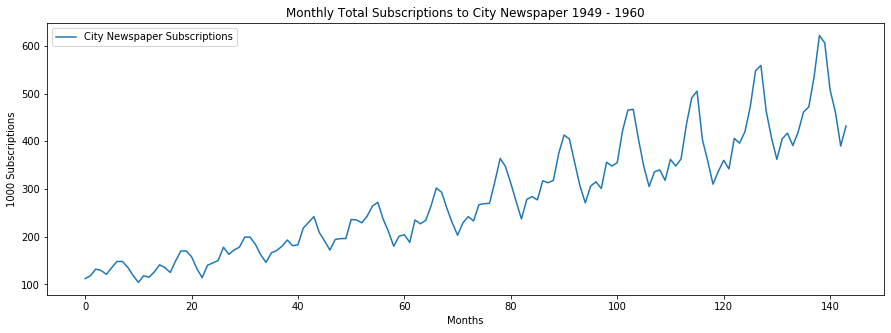

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(data, label = "City Newspaper Subscriptions")
plt.xlabel("Months")
plt.ylabel("1000 Subscriptions")
plt.title("Monthly Total Subscriptions to City Newspaper 1949 - 1960")
plt.legend()
plt.show()

Now we are ready to start importing Keras' modules.

In [ ]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

First of all, we need to prepare the data for the training and test stage. Once the data is loaded, we normalize the input values and split them between training (70%) and testing (30%).


In [ ]:
# convert pandas data frame in numpy array of float.
data_np = data.values.astype("float32")

# normalize data with min max normalization
normalizer = MinMaxScaler(feature_range = (0, 1))
dataset = normalizer.fit_transform(data_np)

# Using 70% of data for training, 30% for test.
TRAINING_PERC = 0.70

train_size = int(len(dataset) * TRAINING_PERC)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of samples training set: " + str((len(train))))
print("Number of samples test set: " + str((len(test))))

Number of samples training set: 100
Number of samples test set: 44


We also arrange the dataset (input and labels) in the appropriate Keras' format by using the helper function `create_dataset()`. 

`create_dataset()` takes as argument the variable `window_size`. This variable is highly important when dealing with sequences since it is going to determine the length of our input data to the network. For instance, by setting `window_size` to 5, we will be using the last 5 monthly subscriptions values to predict the next one. 

In [ ]:
# helper function to read data.
def create_dataset(dataset, window_size = 1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - 1):
        sample = dataset[i:(i + window_size), 0]
        data_x.append(sample)
        data_y.append(dataset[i + window_size, 0])
    return(np.array(data_x), np.array(data_y))

# Create test and training sets for regression with window size 5.
window_size = 5
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

print("Shape of training inputs: " + str((train_X.shape)))
print("Shape of training labels: " + str((train_Y.shape)))

Shape of training inputs: (94, 5, 1)
Shape of training labels: (94,)


Once all the data is ready, we create the model as a `Sequential` object including 16 LSTM units and a dense layer outputting a single scalar.
As mentioned, we specify a window size equal to 5, so that the prediction of the current element depends only on the previous five ones.

In [ ]:
batch_size = 32
rnn = Sequential()    
rnn.add(LSTM(16, input_shape = (window_size, 1)))
rnn.add(Dense(1))
rnn.compile(loss = "mean_squared_error",  optimizer = "adam", metrics = ['mse'])

rnn.fit(train_X, train_Y, epochs=500, batch_size=batch_size, verbose = 0)

Now we can compute the MSE on the training and test data:

In [ ]:
def get_predict_and_score(model, X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability.
    orig_data = normalizer.inverse_transform([Y])
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

mse_train, train_predict = get_predict_and_score(rnn, train_X, train_Y)
mse_test, test_predict = get_predict_and_score(rnn, test_X, test_Y)

print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)

Training data error: 24.90 MSE
Test data error: 55.46 MSE


Moreover, we can plot the predictions and actual values in a graph to check visually the performance of our predictor.

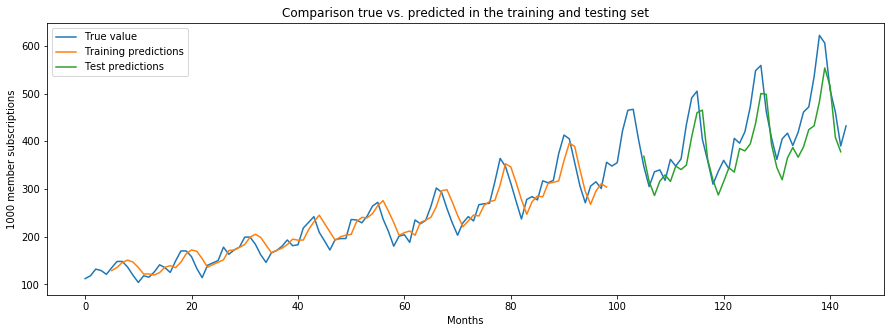

In [ ]:
# Training predictions.
train_predictions = np.empty_like(dataset)
train_predictions[:, :] = np.nan
train_predictions[window_size:len(train_predict) + window_size, :] = train_predict

# Test predictions.
test_predictions = np.empty_like(dataset)
test_predictions[:, :] = np.nan
test_predictions[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(normalizer.inverse_transform(dataset), label = "True value")
plt.plot(train_predictions, label = "Training predictions")
plt.plot(test_predictions, label = "Test predictions")
plt.xlabel("Months")
plt.ylabel("1000 member subscriptions")
plt.title("Comparison true vs. predicted in the training and testing set")
plt.legend()
plt.show()

#Sequence Modelling: Text

Now we will use RNNs to tackle text examples. We will present two problems: classification and generation.

A small summary of both problems is given below.

**Classification**

Classification is a standard problem, where we have some input data $x$ and try to classify it as one of the available classes $y$. In the case of sequential data, though, $x$ will be a sequence of elements that will be processed by the RNN to return the label $y$. The image depicts a sequence classification problem, where the red blocks are inputs, the green blocks the RNN model, and the blue block is the output. Hate speech detection could be an example of text classification with RNNs, where for instance the architecture must identify if an input text contains racist or sexist language, among others. 

![alt text](https://i.ibb.co/TtZPpZr/Capture.jpg)


**Generation**

In a generation problem, we aim to generate a sequence $y$ following the same distribution as the real data $x$. We will input the sequence into the model, and we will output another sequence $y$. Text translation is a typical example of many to many RNNs.

![](https://i.ibb.co/7gSwnT2/Capture.jpg)



## Preliminary imports

Here we include some of the used imports during the tutorial. Just run it to import the necessary modules.

In [ ]:
## These are just a bunch of imports
## Just run them
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Flatten, Add, Lambda
from keras.layers import LSTM, CuDNNLSTM
from keras.datasets import imdb

from keras import __version__
from keras import backend as K


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

print('Using Keras version:', __version__, 'backend:', K.backend())
K.tensorflow_backend._get_available_gpus()
session = tf.Session(config=tf.ConfigProto(log_device_placement=True))
K.set_session(session)

Using Keras version: 2.2.5 backend: tensorflow
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



# Text Classification 

**References:** 

https://colab.research.google.com/github/csc-training/intro-to-dl/blob/master/day1/keras-imdb-rnn.ipynb#scrollTo=BYu8ql1nG7xc

For the text classification example we will use the IMDB dataset available in Keras. The dataset includes tens of thousands of movie reviews taken from the IMDB website with a corresponding label for each review. The label is binary, and indicates if the review has a positive or negative sentiment. This problem is a quite standard Natural Language Processing problem, and it is called sentiment classification or sentiment analysis.

Before loading the data and building our model, we will explain a common part of NLP models, the embeddings.

### Embeddings
**References:** 

[1] https://nlp.stanford.edu/projects/glove/

[2] https://colab.research.google.com/drive/1oXjNYSJ3VsRvAsXN4ClmtsVEgPW_CX_c?hl=en#scrollTo=p9q7qfXrvq-J


Usually, the first step of text modelling is transforming the words into a vector. We will encode the sequences in integer numbers, and we will also have a dictionary that contains the relationship `(actual word, integer)`. For example, the sentence "the cat is on the table and the dog is on the mat" can be encoded in the form $(7, 1, 3, 5, 7, 6, 0, 7, 2, 3, 5, 7, 4)$, with the corresponding dictionary $(and, 0), (cat, 1), (dog, 2)\dots (the, 7)$. In a code form, the representation is done like this:

In [ ]:
sentence = 'the cat is on the table and the dog is on the mat'
## We form a list of unique words by using a set
## which returns only unique elements
## we also sort them, which is not necessary
sentence_set = sorted(set(sentence.split(' ')))
words = list(sentence_set)
## We now form a dictionary in the form of 
## e.g. dict_words[and] = 1
dict_words = dict((word, i) for i, word in enumerate(words))
## We now encode the sentence in a list of integers
encoded_sentence = [dict_words[w] for w in sentence.split()]
print(sentence_set)
print(encoded_sentence)
print(dict_words)

['and', 'cat', 'dog', 'is', 'mat', 'on', 'table', 'the']
[7, 1, 3, 5, 7, 6, 0, 7, 2, 3, 5, 7, 4]
{'and': 0, 'cat': 1, 'dog': 2, 'is': 3, 'mat': 4, 'on': 5, 'table': 6, 'the': 7}


Keras contains a class called `Tokenizer` that helps in performing this process. We will not use it for the examples in this tutorial, as we want to show all the steps involved in the tokenization process, but the `Tokenizer` class provides a high-level way to handle this preprocessing step. As it can be quite useful, we provide a small overview of it. [Here](https://keras.io/preprocessing/text/) you have a link to the Keras documentation explaining the different arguments of the class.

In [ ]:
import keras
## First you define a tokenizer object
## If you want a character level tokenization we set char_level=True
## If set to false, it will tokenize in a word level
## You can check in the documentation the different arguments
tokenizer = keras.preprocessing.text.Tokenizer(char_level=False)
## Then you fit it on the data you have
## The method expects a list of sentences
tokenizer.fit_on_texts([sentence])


In [ ]:
## Now, the class has formed a dictionary with all the words
print(tokenizer.word_index)


{'the': 1, 'is': 2, 'on': 3, 'cat': 4, 'table': 5, 'and': 6, 'dog': 7, 'mat': 8}


In [ ]:
## You can also check the word count
print(tokenizer.word_counts)

OrderedDict([('the', 4), ('cat', 1), ('is', 2), ('on', 2), ('table', 1), ('and', 1), ('dog', 1), ('mat', 1)])


In [ ]:
## You can transform the data to sequences of integers
## We print the first 10 elements
tokenizer.texts_to_sequences([sentence])

[[1, 4, 2, 3, 1, 5, 6, 1, 7, 2, 3, 1, 8]]

Now that we have the sequence in the form of a list of integers,  we could input that directly to the RNN. However, it would be really hard for the RNN to understand the relationships between the words. To give the model more representation power, we first want to transform the integer to a vector of dimension $d$ which represents the semantic meaning of the words. Each of these vectors is called an Embedding. The actual values of the vectors are not important, only the relationships between them. For example, `dog` and `cat` vectors are probably going to be closer than `dog` and `the`.

 The embeddings can be initialized randomly and the model will learn suitable values to reduce the loss during the training process. However, embeddings which have already been trained in a large corpus of text such as Wikipedia can also be used. Examples of these pretrained embeddings are [Word2Vec](https://en.wikipedia.org/wiki/Word2vec) or  [GloVe](https://nlp.stanford.edu/projects/glove/). These methods are trained using the context of the words, for example predicting the surrounding words when an specific word is given. As a result, words that appear in similar contexts have closer embeddings.

![alt text](https://i.ibb.co/s5sg6dZ/Screenshot-from-2019-02-08-15-13-41.png) 

The image shows relationships between words in the embedding space.



We now download the GloVe pretrained vectors trained in Wikipedia and Gigaword. [Here](https://nlp.stanford.edu/projects/glove/) you have an overview of what GloVe is. We will see how the embeddings contain a semantic meaning that allows us to model semantic relationships. The time it takes to download the embeddings may vary, it should be around 6-7 minutes.

In [ ]:
## Download and unzip glove pretrained embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!apt-get -qq install unzip
!unzip glove.6B.zip

--2020-02-14 19:00:27--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-02-14 19:00:27--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-02-14 19:00:28--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

We will now load the GloVe embeddings. We use gensim to manipulate the embeddings, which is a nice tool that can be used to play with GloVe or Word2Vec embeddings. This piece of code also takes some time to load, as the embeddings file is quite large.

In [ ]:
## We load the embeddings
## Gensim is a really useful module that provides high-level function
## to use with the embeddings
!pip install gensim
from gensim.models import word2vec
from gensim.scripts.glove2word2vec import glove2word2vec
## These next three lines just load the embeddings into the object glove_model
glove2word2vec(glove_input_file="glove.6B.300d.txt", word2vec_output_file="gensim_glove_vectors.txt")
from gensim.models.keyedvectors import KeyedVectors
glove_model = KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Now we will do some operations using the embeddings of the words. First, we will do some words arithmetics based on the embeddings so you can see how they contain some meaning. For example, the distance between words with similar semantic meaning but different genders is kind of constant. Meaning that the vector resulting from doing $man - woman$ should be similar to $king - queen$, hence:

$king - queen \approx man - woman \rightarrow woman + king - man \approx queen$

We can check this using the method `most_similar` and the `positive` and `negative` arguments as following:



In [ ]:
## We can do word arithmetics. 
## We look for the nearest neighbour of the vector resulting on doing
## the operation 'king' + 'woman' - 'man'
glove_model.most_similar(positive=['woman', 'king'], negative=['man'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('queen', 0.6713277101516724),
 ('princess', 0.5432624220848083),
 ('throne', 0.5386104583740234),
 ('monarch', 0.5347574949264526),
 ('daughter', 0.498025119304657),
 ('mother', 0.4956442713737488),
 ('elizabeth', 0.4832652509212494),
 ('kingdom', 0.47747087478637695),
 ('prince', 0.4668239951133728),
 ('wife', 0.4647327661514282)]

In [ ]:
## Similar examples
glove_model.most_similar(positive=['google', 'ios'], negative=['apple'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('android', 0.5720318555831909),
 ('apps', 0.5662358999252319),
 ('app', 0.5322650671005249),
 ('facebook', 0.4770544171333313),
 ('smartphones', 0.47069066762924194),
 ('gmail', 0.4677259922027588),
 ('firefox', 0.4666402041912079),
 ('skype', 0.4491073191165924),
 ('iphone', 0.44582629203796387),
 ('web-based', 0.44464385509490967)]

In [ ]:
glove_model.most_similar(positive=['england', 'paris'], negative=['france'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('london', 0.6710129976272583),
 ('manchester', 0.5267472863197327),
 ('birmingham', 0.49347949028015137),
 ('liverpool', 0.49033817648887634),
 ('oxford', 0.4811282157897949),
 ('middlesex', 0.47516536712646484),
 ('surrey', 0.46148526668548584),
 ('sussex', 0.45899876952171326),
 ('leeds', 0.4551934599876404),
 ('essex', 0.45398280024528503)]

In [ ]:
## We can also check the word that does not match the rest
glove_model.doesnt_match("breakfast cereal dinner lunch".split())

/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'cereal'

To check out other functions you can call use [this](https://radimrehurek.com/gensim/models/keyedvectors.html#module-gensim.models.keyedvectors).


In http://projector.tensorflow.org/ you can visualize the words projected in the $\mathbb{R}^3$ space using either PCA or tSNE, which are both techniques for dimensionality reduction. There, you can see how words are clustered by meaning or topic.


![](https://brenndoerfer.github.io/deep-sentiment-analysis-distill/img/tensorboard_projector.gif)

Image taken from [here](https://brenndoerfer.github.io/deep-sentiment-analysis-distill/index.html)

### IMDB
Now let's start with the text classification problem. We first load the IMDB dataset for sentiment classification. As we said, it contains movie reviews with a corresponding binary sentiment label. The words are already encoded as integers in order from most common words to less common (e.g. `the` is a common word so it should be encoded as a small integer). That makes it easy to filter the non-common words by using the argument `num_words` when loading the data. The filtered words will be all encoded as a special token `<UNK>`, which means unknown. For example, if we want to load the dataset with only the top $20000$ most common words we can do this:

In [ ]:
# number of most-frequent words to use
nb_words = 20000

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=nb_words)
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)

Loading data...
17465344/17464789 [==============================] - 1s 0us/step
x_train: (25000,)
x_test: (25000,)


We see that the dataset contains 25000 examples for both train and testing. Let's print an example.

In [ ]:
print(x_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


The printed example is a sequence of numbers. It is important to note that there are three special integers in this IMDB dataset: $0$, $1$ and $2$. $0$ will be used to pad the sequences, which we will explain now. $1$ is used as the `<START>` token (you can see how the printed sequence starts with a `1`). $2$ is the token `<UNK>` which is used for all the filtered non-common words. If we want to retrieve the actual sentence, we can use the dictionary given when using the method `get_word_index()`. However, the given dictionary when calling `get_word_index()` does not take into account the three mentioned tokens, so we need to modify it a little bit.

In [ ]:
# get_word_index retrieves a mapping word -> index
word_index = imdb.get_word_index()
# We make space for the three special tokens
word_index_c = dict((w, i+3) for (w, i) in word_index.items())
word_index_c['<PAD>'] = 0
word_index_c['<START>'] = 1
word_index_c['<UNK>'] = 2
# Instead of having dictionary word -> index we form
# the dictionary index -> word
index_word = dict((i, w) for (w, i) in word_index_c.items())
# We now retrieve the sentence
sentence = ''
for index in x_train[0]:
  sentence += index_word[index] + ' '
print(sentence)

1646592/1641221 [==============================] - 1s 0us/step
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile fo

We can see how we just recovered the sentence that we had printed before as a sequence of numbers. We can also see how there is no punctuation in this dataset.

One of the problems with the given text data is that the sequences all have a different length. We want to give Keras a batch of inputs with fixed dimensions. To do so, we define a maximum length `maxlen`, and truncate the sentences longer than that, and also pad with $0$'s at the beginning the sentences shorter than that length. We use the method `sequence.pad_sequence` from `keras.preprocessing`

In [ ]:
# Truncate sentences after this number of words
maxlen = 80
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)


We can check how some sentences are padded at the beginning to be of length `maxlen`.

In [ ]:
x_train[5]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     1,   778,   128,    74,    12,   630,   163,    15,
           4,  1766,  7982,  1051,     2,    32,    85,   156,    45,
          40,   148,   139,   121,   664,   665,    10,    10,  1361,
         173,     4,   749,     2,    16,  3804,     8,     4,   226,
          65,    12,    43,   127,    24, 15344,    10,    10],
      dtype=int32)

We will now build the model we will use for sentiment classification. The model is formed by an Embedding layer, where the model will learn a vector of dimensionality `embedding_dim` for each of the words; a LSTM layer and a linear layer that maps the output of the LSTM to 1 value. We use CuDNNLSTM instead of LSTM, which is just a faster implementation of LSTM when using GPU, as in our case. We train this with the `binary_crossentropy` loss and `sigmoid` activation as we only have two classes. 

In [ ]:
## Model parameters:
# Dimensions of the embeddings
embedding_dim = 300
## LSTM dimensionality
lstm_units = 128

print('Build model...')
text_class_model = Sequential()

text_class_model.add(Embedding(nb_words,
                    embedding_dim,
                    input_length=maxlen))

# model.add(LSTM(lstm_units))
# CuDNNLSTM is a faster implementation of LSTM if running on a GPU:
text_class_model.add(CuDNNLSTM(lstm_units))

# To stack multiple RNN layers, all RNN layers except the last one need
# to have "return_sequences=True".  An example of using two RNN layers:
# model.add(CuDNNLSTM(lstm_units, return_sequences=True))
# model.add(CuDNNLSTM(lstm_units))


# You can add some dropout if you want
# model.add(Dropout(0.5))

text_class_model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
text_class_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(text_class_model.summary())

Build model...
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 80, 300)           6000000   
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 128)               220160    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 6,220,289
Trainable params: 6,220,289
Non-trainable params: 0
_________________________________________________________________
None


Let's train it for 5 epochs.

In [ ]:
## We train the model for 5 epochs and check the accuracy in a validation split
epochs = 5
validation_split = 0.2

history = text_class_model.fit(x_train, y_train, batch_size=128,
          epochs=epochs, validation_split=validation_split)


Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 4s 201us/step - loss: 0.5041 - acc: 0.7427 - val_loss: 0.3728 - val_acc: 0.8356
Epoch 2/5
20000/20000 [==============================] - 2s 118us/step - loss: 0.2744 - acc: 0.8887 - val_loss: 0.3780 - val_acc: 0.8342
Epoch 3/5
20000/20000 [==============================] - 2s 116us/step - loss: 0.1691 - acc: 0.9384 - val_loss: 0.4378 - val_acc: 0.8250
Epoch 4/5
20000/20000 [==============================] - 2s 117us/step - loss: 0.1000 - acc: 0.9660 - val_loss: 0.5723 - val_acc: 0.8204
Epoch 5/5
20000/20000 [==============================] - 2s 117us/step - loss: 0.0592 - acc: 0.9819 - val_loss: 0.8404 - val_acc: 0.8084


This is a classification example, so let's print the loss and the classification accuracy.

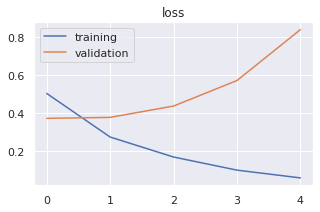

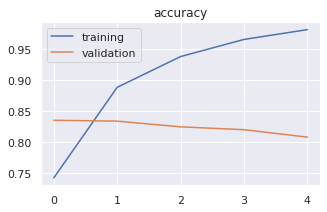

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'], label='training')
plt.plot(history.epoch,history.history['val_loss'], label='validation')
plt.title('loss')
plt.legend(loc='best')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'], label='training')
plt.plot(history.epoch,history.history['val_acc'], label='validation')
plt.title('accuracy')
plt.legend(loc='best');

It looks like we could have stopped the training in the first epoch as the validation loss did not decrease afterwards.

In [ ]:
# Let's see the accuracy in the test split
scores = text_class_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (text_class_model.metrics_names[1], scores[1]*100))

acc: 80.43%


### Saving best performing model

Now we save the best performing models using the validation loss as a metric. As you already know, lower training error does not mean in some cases better performance in the validation or test split.

In the last example we ran the model for 5 epochs, however after the first epoch the validation loss increased. We want to use the model performing the best in the validation set. To do so, we can use a ModelCheckpoint callback as was explained in past tutorials.

In [ ]:
###### We reset the model #######
text_class_model = Sequential()
text_class_model.add(Embedding(nb_words,
                    embedding_dim,
                    input_length=maxlen))
text_class_model.add(CuDNNLSTM(lstm_units))
text_class_model.add(Dense(1, activation='sigmoid'))
text_class_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
#################################


from keras.callbacks import ModelCheckpoint
## Here we define the checkpoint callback. We first give the name it will use 
## to save the model. We also specify what metric should monitor, in this case
## the validation loss (it could be validation accuracy too for example)
## save_best_only means that the models will only be save when the monitored 
## metric improves with respect to the past best one
checkpoint = ModelCheckpoint('model-{epoch:03d}.h5', verbose=1, 
                             monitor='val_loss',save_best_only=True)  
## Now we pass the callback to the fit method
history = text_class_model.fit(x_train, y_train, batch_size=128,
          epochs=epochs, callbacks=[checkpoint],
          validation_split=validation_split)



Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 4s 196us/step - loss: 0.4544 - acc: 0.7817 - val_loss: 0.3900 - val_acc: 0.8292

Epoch 00001: val_loss improved from inf to 0.38997, saving model to model-001.h5
Epoch 2/5
20000/20000 [==============================] - 2s 116us/step - loss: 0.2485 - acc: 0.9013 - val_loss: 0.3913 - val_acc: 0.8250

Epoch 00002: val_loss did not improve from 0.38997
Epoch 3/5
20000/20000 [==============================] - 2s 116us/step - loss: 0.1466 - acc: 0.9477 - val_loss: 0.4902 - val_acc: 0.8242

Epoch 00003: val_loss did not improve from 0.38997
Epoch 4/5
20000/20000 [==============================] - 2s 116us/step - loss: 0.0923 - acc: 0.9682 - val_loss: 0.5292 - val_acc: 0.8176

Epoch 00004: val_loss did not improve from 0.38997
Epoch 5/5
20000/20000 [==============================] - 2s 116us/step - loss: 0.0546 - acc: 0.9814 - val_loss: 0.7334 - val_acc: 0.8110

Epoch 00005: val_loss did n

We now saved the model after every epoch if the validation loss decreased. In this case, as the best epoch is the first one, it only saves the model after the first epoch. Let's load the model now.

In [ ]:
from keras.models import load_model
text_class_model = load_model('model-001.h5')  # load model weights

And now we check if the accuracy is better compared to when we used the model trained the model for 5 epochs.

In [ ]:
# Let's see the accuracy in the test split
scores = text_class_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (text_class_model.metrics_names[1], scores[1]*100))

acc: 83.17%


As we can see, the accuracy is slightly better! 

### Importance of embeddings
Now, let's check quickly if using Embeddings provide any benefit. For this experiment, we remove the Embedding layer, meaning we will be inputting the word index, i.e. an integer, to the LSTM. Additionally, we need to vary the shape of the input data as the LSTM needs a third dimension with the number of channels per input (in this case 1, as each word is represented by only a number).

In [ ]:
# model parameters
# Same model as before but without embeddings
lstm_units = 128
x_train_r = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test_r = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


print('Build model...')
text_class_model = Sequential()

text_class_model.add(CuDNNLSTM(lstm_units, input_shape=(maxlen, 1)))

text_class_model.add(Dense(1, activation='sigmoid'))

text_class_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(text_class_model.summary())

Build model...
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_5 (CuDNNLSTM)     (None, 128)               67072     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 67,201
Trainable params: 67,201
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
epochs = 5
validation_split = 0.2

history = text_class_model.fit(x_train_r, y_train, batch_size=128,
          epochs=epochs, 
          validation_split=validation_split)


Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 3s 153us/step - loss: 0.6930 - acc: 0.5184 - val_loss: 0.6899 - val_acc: 0.5462
Epoch 2/5
20000/20000 [==============================] - 1s 65us/step - loss: 0.6898 - acc: 0.5299 - val_loss: 0.6864 - val_acc: 0.5512
Epoch 3/5
20000/20000 [==============================] - 1s 67us/step - loss: 0.6871 - acc: 0.5428 - val_loss: 0.6809 - val_acc: 0.5782
Epoch 4/5
20000/20000 [==============================] - 1s 65us/step - loss: 0.6874 - acc: 0.5419 - val_loss: 0.6868 - val_acc: 0.5500
Epoch 5/5
20000/20000 [==============================] - 1s 68us/step - loss: 0.6862 - acc: 0.5490 - val_loss: 0.6866 - val_acc: 0.5582


In [ ]:
scores = text_class_model.evaluate(x_test_r, y_test, verbose=2)
print("%s: %.2f%%" % (text_class_model.metrics_names[1], scores[1]*100))

acc: 54.03%


We see how the accuracy is just slightly better compared to doing a random guess as there are only 2 classes. Hence, using embeddings results in models with better capacity/accuracy for this kind of tasks.

Instead of inputting directly integers to the RNN, we could argue that another way of representing the input words is to input the one-hot representation of the word directly to the RNN instead of using embeddings. This method has two problems. First, the resulting dimensionality would be too large. In this case we are loading the $20000$ most common words in IMDB, so each word would be encoded in a vector of dimensionality $20000$. Secondly, the encoding does not give any notion of similarity between the different words. For these two reasons, embedding the words to a common lower dimensionality space is also better than using one-hot encoding.

# Text Generation

We now will use RNNs to generate new text samples. [Recent advances](https://openai.com/blog/better-language-models/) have made models capable of generating convincing text samples. An example can be found in https://talktotransformer.com/. State-of-the-art architectures for text generation do not use RNNs, they use an archictecture called Transformer. However, RNNs provide an easy way to tackle text generation due to their sequential nature.

We now will present an example of text generation using a RNN. We will use the Tiny Shakespeare dataset, which contains samples from Shakespeare works.

We pose the problem as a classification problem as in the Sentiment classification example. In a text generation setting, given a sequence, we aim to predict the next one. During the training step, the process would be quite similar to the classification task, i.e. given a sequence you predict a label/word/character. However, in the prediction setting, we aim to output a whole sentence, not only a word or character. For that reason we will follow the procedure explained in the image.

![](https://cdn-images-1.medium.com/max/1600/1*XvUt5wDQA8D3C0wAuxAvbA.png)
The image is taken from [here](https://medium.com/@david.campion/text-generation-using-bidirectional-lstm-and-doc2vec-models-1-3-8979eb65cb3a)

As in the text classification section, we encode the raw sentences in the form of a sequence of integers. In this case, however, we have a text with a really wide vocabulary, and we aim to predict the following element of the sequence. In this dataset the number of words is really large, so if we used a word-level model the number of available classes would be quite large. For this reason, instead of encoding on a word level, we will do it on a character level, which results in a more limited vocabulary. We aim to predict the next character when inputting a sentence of length $d$. In evaluation mode, i.e. when we are predicting the next character, we then input a seed of $d$ characters as the first input, and afterwards we use the last $d$ characters as input to predict the next character. 

The advantages of predicting characters instead of words is that character level models have a limited vocabulary/classes compared to the number of possible words in a text. However, word level models usually present higher performance as it easier for them to keep track of the long-term meaning of the sentence.

**References:** Some code snippets taken from [here](https://www.analyticsvidhya.com/blog/2018/03/text-generation-using-python-nlp/)


We first download the data we use for the example, and then read the file. 

In [ ]:
!wget https://raw.githubusercontent.com/jcjohnson/torch-rnn/master/data/tiny-shakespeare.txt
## We read all the raw data in the variable data
data = open('./tiny-shakespeare.txt', 'r').read()

--2020-02-14 19:10:40--  https://raw.githubusercontent.com/jcjohnson/torch-rnn/master/data/tiny-shakespeare.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘tiny-shakespeare.txt’

tiny-shakespeare.tx 100%[===================>]   1.06M  --.-KB/s    in 0.02s   

2020-02-14 19:10:41 (45.2 MB/s) - ‘tiny-shakespeare.txt’ saved [1115394/1115394]



Let's print a subset of the data for visualization purposes.

In [ ]:
print(data[:364])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?


We see in the raw text that the name of the characters is printed, that there is a blank line between the different character lines, and that lines are usually not longer than ~80 characters. We hope the network is capable of learning all of this.

Now we put the data in a more structured way. We aim to encode the text using a sequence of integers as we explained in the classification section.  Hence, we form a dictionary with all the different characters appearing in the text (including whitespaces and punctuation) and its corresponding integer. 

In [ ]:
characters = sorted(list(set(data)))
n_to_char = {n:char for n, char in enumerate(characters)}
char_to_n = {char:n for n, char in enumerate(characters)}

Now we want to split the text in examples of length `seq_length` where the label is the next character. To do so, we use the dictionary `char_to_n` to encode the different elements as a sequence of integers.


In [ ]:
x = []
y = []
length = len(data)
seq_length = 100
for i in range(0, length-seq_length, 1):
  sequence = data[i:i + seq_length]
  label = data[i + seq_length]
  x.append([char_to_n[char] for char in sequence])
  y.append(char_to_n[label])
n_samples = len(x)
print("Total Samples: {:d}".format(n_samples))

Total Samples: 1115294


We now form a test split by using 5% of the available data. To do so, we just take the last 5% of the data. Usually, you need to randomize the data before splitting in test/train to avoid having different distribution of the data in both splits. However, as this is a sequential data where we want to predict the next character, if we shuffle the splits we would have this in training:

``
x = 'the boy is tal_' y = 'l'
``

and this in testing:

``
x = 'the boy is ta_' y = 'l'
``

which would contaminate the splits.

In [ ]:
import keras
x_train = x[:int(n_samples*0.95)]
x_test = x[int(n_samples*0.95):]
y_train = y[:int(n_samples*0.95)]
y_test = y[int(n_samples*0.95):]

## Transform the list to a numpy array
x_train = np.reshape(x_train, (len(x_train), seq_length))
## Onehot encoding of labels
y_train = keras.utils.to_categorical(np.asarray(y_train))

x_test = np.reshape(x_test, (len(x_test), seq_length))
y_test = keras.utils.to_categorical(np.asarray(y_test))


Let's print a sequence and the shape of the labels.

In [ ]:
print(x_train[8000])
print(y_train.shape)

[ 0 13  1 57 47 41 49  1 51 39 52  5 57  1 39 54 54 43 58 47 58 43  6  1
 61 46 53  1 42 43 57 47 56 43 57  1 51 53 57 58  1 58 46 39 58  0 35 46
 47 41 46  1 61 53 59 50 42  1 47 52 41 56 43 39 57 43  1 46 47 57  1 43
 60 47 50  8  1 20 43  1 58 46 39 58  1 42 43 54 43 52 42 57  0 33 54 53
 52  1 63 53]
(1059529, 65)


Here, we define the model. As we want to give it a little bit more of capacity to our model, we use two different LSTM stacked on top of each other. To do so, we need to use the `return_sequences=True` in the first of the two LSTM. If you want to know a little bit more about the `return_sequences` argument, you can check [this reference](https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/).

In [ ]:
# define the LSTM model
embedding_size = 300
lstm_units = 256

text_gen_model = Sequential()
text_gen_model.add(Embedding(y_train.shape[1],
                    embedding_size, input_length=seq_length))
text_gen_model.add(CuDNNLSTM(lstm_units, return_sequences=True))
text_gen_model.add(Dropout(0.2))
text_gen_model.add(CuDNNLSTM(lstm_units))
text_gen_model.add(Dropout(0.2))
text_gen_model.add(Dense(y_train.shape[1], activation='softmax'))

text_gen_model.compile(loss='categorical_crossentropy', optimizer='adam')
text_gen_model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 300)          19500     
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 100, 256)          571392    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 256)          0         
_________________________________________________________________
cu_dnnlstm_7 (CuDNNLSTM)     (None, 256)               526336    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 65)                16705     
Tota

The model is a little bit complex, so training takes some time.

In [ ]:
text_gen_model.fit(x_train, y_train, epochs=10 , batch_size=128)

Epoch 1/10
1059529/1059529 [==============================] - 335s 316us/step - loss: 1.7868
Epoch 2/10
1059529/1059529 [==============================] - 332s 314us/step - loss: 1.4827
Epoch 3/10
1059529/1059529 [==============================] - 334s 315us/step - loss: 1.4157
Epoch 4/10
1059529/1059529 [==============================] - 335s 316us/step - loss: 1.3818
Epoch 5/10
1059529/1059529 [==============================] - 335s 317us/step - loss: 1.3584
Epoch 6/10
1059529/1059529 [==============================] - 334s 315us/step - loss: 1.3425
Epoch 7/10
1059529/1059529 [==============================] - 336s 317us/step - loss: 1.3316
Epoch 8/10
1059529/1059529 [==============================] - 335s 316us/step - loss: 1.3224
Epoch 9/10
1059529/1059529 [==============================] - 334s 316us/step - loss: 1.3160
Epoch 10/10
1059529/1059529 [==============================] - 334s 315us/step - loss: 1.3107


### Prediction

We now take any of the sequences from the test split and use it as an initial seed. Then we enter a loop where given an input sequence, we predict the next character and then form a new input sequence by appending the predicted character and dropping the first character.

Whenever we input a sequence, we obtain as output a probability distribution of the possible characters. For example, given the sequence `the cat and the do` the model will output a probability distribution of the next character where probably the character `g` will have a high probability (forming then `the cat and the dog`). However, the character `c` can also be a possibility, as the sentence formed may be `the cat and the doctor`. When deciding what character to predict, a strategy is to just take the character with the maximum probability at all times. However, the variability of the formed text is then smaller. Another option would be to sample following the same probability of distribution as the model outputs. However, this might result in a large variability with some sentences not making any sense.

This trade-off of variability against more probable sequences is controlled by what it is called the temperature of the sampling process. The temperature controls the smoothing on the probability vector. A temperature close to 0 will result in taking always the safest (i.e. that with the highest probability) as the next element. A temperature close to 1 will decide on the next element following the same distribution of probability as the original output of the model.

In a more formal way, being $p_i$ the probability of the element $i$ output by the RNN model and $T$ the temperature, the probability after applying the mentioned smoothing $\hat{p_i}$ is:

$$
\hat{p_i} = \frac{e^{\log(p_i)/T}}{\sum_j e^{\log(p_j)/T}}
$$

You can check how a small $T$ is going to make the element with the largest probability be close to 1 after the process.

Before starting the text prediction, let's show an example of how the sampling temperature affects the model choices.

In [ ]:
def temperature_smoothing(prediction, temperature=1.0):
  # This function computes the temperature smoothing function
  # we explained
  prediction = np.log(prediction + 1e-7) / (temperature + 0.01)
  exp_preds = np.exp(prediction)
  prediction = exp_preds / np.sum(exp_preds)
  return prediction

# We have this vector of probabilities
prediction = np.asarray([0.2, 0.3, 0.1, 0.4])
## Temperature = 1.0
print('Output probabilities with temp.=1')
print(temperature_smoothing(prediction, temperature=1))
## Temperature = 0.5
print('Output probabilities with temp.=0.5')
print(temperature_smoothing(prediction, temperature=0.5))
## Temperature = 0.25
print('Output probabilities with temp.=0.25')
print(temperature_smoothing(prediction, temperature=0.25))
## Temperature = 0.0
print('Output probabilities with temp.=0')
print(temperature_smoothing(prediction, temperature=0))

Output probabilities with temp.=1
[0.20065194 0.29977201 0.10101691 0.39855913]
Output probabilities with temp.=0.5
[0.13579339 0.30071527 0.03488383 0.5286075 ]
Output probabilities with temp.=0.25
[0.04948661 0.23537565 0.00344097 0.71169677]
Output probabilities with temp.=0
[7.88880627e-31 3.20722891e-13 6.22348202e-61 1.00000000e+00]


You can see how a lower temperature makes the small probabilities become smaller and the biggest probability become bigger.

Here you can set the temperature and check how the output varies. You will see that for $T\approx0$ the generated text is pattern like, with low variability.

In [ ]:
import sys
# Vary the temperature here
temperature = 0.5

# We select a random element from the test set as seed
start = np.random.randint(0, len(x_test)-1)
pattern = x_test[start].tolist()
print("Seed:")
print("\"", ''.join([n_to_char[value] for value in pattern]), "\"")

print("\nPredicted:")
# generate 300 characters
for i in range(300):
  x = np.reshape(pattern, (1, len(pattern)))
  prediction = text_gen_model.predict(x, verbose=0).astype(np.float64)
  ## We put the constant 0.02 to avoid dividing by zero
  ## We sum by 1e-7 to avoid log(0)
  prediction = np.log(prediction + 1e-7) / (temperature + 0.01)
  exp_preds = np.exp(prediction)
  prediction = exp_preds / np.sum(exp_preds)
  ## We applied the smoothing with the temperature
  ## Now we predict following the probabilities in the variable prediction
  prediction = np.random.multinomial(1, prediction[0,:], 1)
  index = np.argmax(prediction)
  result = n_to_char[index]
  seq_in = [n_to_char[value] for value in pattern]
  ## Print the result
  sys.stdout.write(result)
  
  ## Create the input sequence for the next character by appending the predicted
  ## character and dropping the first one to always have constant seq. length
  pattern.append(index)
  pattern = pattern[1:]


Seed:
" revent me; I had peopled else
This isle with Calibans.

PROSPERO:
Abhorred slave,
Which any print of "

Predicted:
 the windows to take
As were not than a soul heart to my state,
The heavy day of a very great rest,
And his father was a profession of revenge.

Provost:
So much at home, the son, and in his book
As he dream to be the instrument news.

First Lord:
No, and so you were as could not be meeting of this


Notice how the network has learnt the structure of the text, to start a new line every few words and to put the name of the characters too. The text itself seems grammatically correct but fails to make much sense in most examples. Test different temperature settings to see how it affects the generation

If you want to know more about text generation, along with some extra generated examples, we refer you to [Andrej Karpathy's blog](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).

### Quantitative evaluation of the generated text

For a quantitative evaluation of the generated text we will use a metric commonly used in image captioning and translation tasks, BLEU. BLEU looks for matches on a word level between the generated text and the reference text. Specifically, BLEU looks for matches in n-grams up to $n=4$, where an n-gram is defined as a contiguous sentence of $n$ items. For example, in the sentence `the sky is blue`, an n-gram of $n=2$ would be `is blue`. 

As we mentioned, the metric is more used in more constraint tasks, such as image captioning. In text generation there is a large number of both grammatically and semantically correct possibilities when generating new sentences, but we hope to see a correlation between the BLEU score and the quality of the generated text. Here we just take different seeds from the test data, and compare the generated sentence to the real one from the corpus. We do so 20 times and provide the average BLEU score.

The used function is integrated in the package `nltk` and it is called using the following syntax `sentence_bleu(reference, candidate).`

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
import sys
temperature = 0.0
bleu_score = 0
n_eval = 20
for _ in range(n_eval):
  start = np.random.randint(0, len(x_test)-len(pattern)-1)
  pattern = x_test[start].tolist()
  reference = x_test[start+len(pattern)].tolist()
  reference = ''.join([n_to_char[value] for value in reference]).split(' ')
  # generate characters
  output_sent = ''
  for i in range(100):
    x = np.reshape(pattern, (1, len(pattern)))
    prediction = text_gen_model.predict(x, verbose=0).astype(np.float64)
    prediction = np.log(prediction + 1e-7) / (temperature + 0.01)
    exp_preds = np.exp(prediction)
    prediction = exp_preds / np.sum(exp_preds)
    prediction = np.random.multinomial(1, prediction[0,:], 1)
    index = np.argmax(prediction)
    result = n_to_char[index]
    seq_in = [n_to_char[value] for value in pattern]
    output_sent += result
    pattern.append(index)
    pattern = pattern[1:]
  candidate = output_sent.replace('\n',' ').split(' ')
  bleu_score += sentence_bleu(reference, candidate)
print(bleu_score/n_eval)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.2911423183777642


# Coursework

### **Task 1: RNN Regression**

In this task, you are asked to estimate the next value of a time series. Specifically, we have selected the airline passenger dataset. This dataset contains the number of passengers that travels with a certain airline company. The data contains 144 entries, one per each month from the year 1949 to the year 1960. 

Similarly to the previous example, we import the data and plot it to see the structure.

In [1]:
# !wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

In [76]:
import warnings
warnings.filterwarnings('ignore')
import pandas
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import numpy as np
import math
from tqdm import tqdm
from pprint import pprint
np.random.seed(0)
##############################################
import pickle
def save_status(data, dest):
    outfile = open(dest, 'wb') 
    pickle.dump(data, outfile)                       
    outfile.close()
def load_status(f): 
    with open(f, 'rb') as infile:     
        status = pickle.load(infile) 
    return status

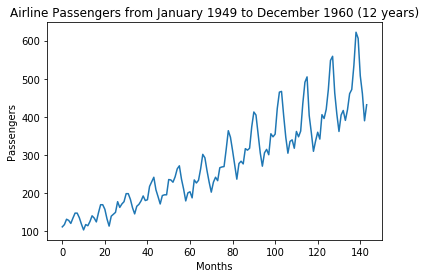

In [77]:
data = pandas.read_csv('airline-passengers.csv', usecols=[1], engine='python')
plt.plot(data)
plt.xlabel("Months")
plt.ylabel("Passengers")
plt.title("Airline Passengers from January 1949 to December 1960 (12 years)")
plt.show()

In [78]:
# convert pandas data frame in numpy array of float.
data_np = data.values.astype("float32")

# normalize data with min max normalization
normalizer = MinMaxScaler(feature_range = (0, 1))
dataset = normalizer.fit_transform(data_np)

# Using 70% of data for training, 30% for test.
TRAINING_PERC = 0.70

train_size = int(len(dataset) * TRAINING_PERC)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of samples training set: " + str((len(train))))
print("Number of samples test set: " + str((len(test))))

Number of samples training set: 100
Number of samples test set: 44


First of all, you need to build the code to train an RNN on the airline passenger dataset based on the last entries. This exercise expects you to study the impact of the `window_size` variable when defining the `train` and `test` dataset splits, where we treat the `test` split as a validation set. 

In [79]:
def create_dataset(dataset, window_size = 1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - 1):
        sample = dataset[i:(i + window_size), 0]
        data_x.append(sample)
        data_y.append(dataset[i + window_size, 0])
    return(np.array(data_x), np.array(data_y))

def get_predict_and_score(model, X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability.
    orig_data = normalizer.inverse_transform([Y])
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

def train_RNN(train_X, train_Y, window_size, batch_size=32):
    rnn = Sequential()    
    rnn.add(LSTM(16, input_shape = (window_size, 1)))
    rnn.add(Dense(1))
    rnn.compile(loss = "mean_squared_error",  optimizer = "adam", metrics = ['mse'])
    rnn.fit(train_X, train_Y, epochs=500, batch_size=batch_size, verbose = 0)
    return rnn

def get_dataset(train, test, window_size):
    # Create test and training sets for regression with different window sizes.
    train_X, train_Y = create_dataset(train, window_size)
    test_X, test_Y = create_dataset(test, window_size)
    train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
    test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))
    return train_X, train_Y, test_X, test_Y
    


In [80]:
win_sizes = list(range(1,31))
results = []

for window_size in tqdm(win_sizes):
    train_X, train_Y, test_X, test_Y = get_dataset(train, test, window_size)
    rnn = train_RNN(train_X, train_Y, window_size)

    mse_train, train_predict = get_predict_and_score(rnn, train_X, train_Y)
    mse_test, test_predict = get_predict_and_score(rnn, test_X, test_Y)
    
    res = {}
    res["window_size"] = window_size
    res["mse_train"] = mse_train
    res["mse_test"] = mse_test
    res["train_predict"] = train_predict
    res["test_predict"] = test_predict
    results.append(res)

100%|██████████| 30/30 [17:27<00:00, 34.92s/it]


In [81]:
picklefile = "checkpoints_06/task1_results"

save_status(results, picklefile)

results = load_status(picklefile)

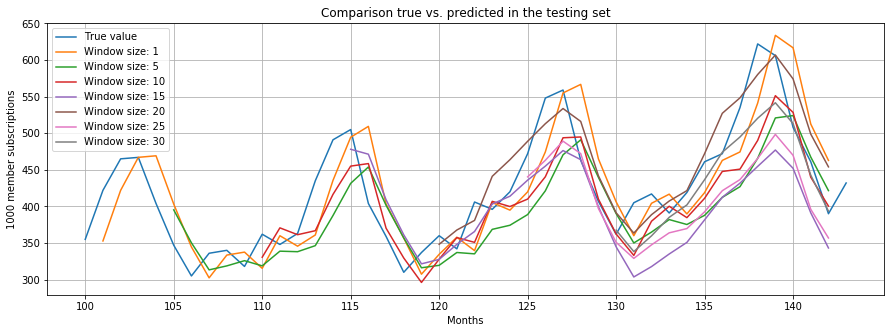

In [97]:
# PLOT TEST PREDICTIONS
plt.figure(figsize = (15, 5))

xrange = range(100,144)
plt.xticks()
plt.plot(xrange, normalizer.inverse_transform(dataset)[-44:], label = "True value")

for res in [results[0]]+results[4::5]:
    window_size = res["window_size"]
    # Training predictions.
    train_predict = res["train_predict"]
    train_predictions = np.empty_like(dataset)
    train_predictions[:, :] = np.nan
    train_predictions[window_size:len(train_predict) + window_size, :] = train_predict

    # Test predictions.
    test_predict = res["test_predict"]
    test_predictions = np.empty_like(dataset)
    test_predictions[:, :] = np.nan
    test_predictions[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict
    plt.plot(xrange,test_predictions[-44:], label = f"Window size: {window_size}")

plt.xticks(range(100,144,5))
plt.xlabel("Months")
plt.ylabel("1000 member subscriptions")
plt.title("Comparison true vs. predicted in the testing set")
plt.legend()
plt.grid()
plt.show()

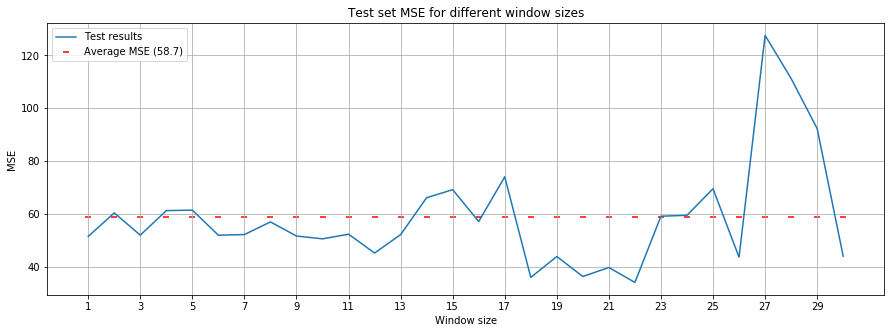

In [105]:
plt.figure(figsize=(15,5))
test_results = [res["mse_test"] for res in results]
xrange = range(1,len(test_results)+1)
plt.plot(xrange, test_results, label="Test results")
plt.scatter(xrange, [np.mean(test_results) for _ in xrange],marker="_",c="red", label=f"Average MSE ({round(np.mean(test_results),1)})")
plt.xticks(range(1,len(test_results)+1,2))
plt.xlabel("Window size")
plt.ylabel("MSE")
plt.title("Test set MSE for different window sizes")
plt.grid()
plt.legend()
plt.show()


**Report**:

*   Report a plot showing the test curves of different models when trained with a range of `window_size` values. Report the plot and discuss the main differences you observe between the predicted curves.

### **Task 2: Text Embeddings Importance**
For this task, we tackle a classification problem using the IMDB sentiment dataset as done in the example above. We will specifically check the importance of the embeddings used for this task. The model you will use for this task is given below, and it should work well for the task of IMDB sentiment classification. As in past tasks, use the given `x_test` and `y_test` as validation for this problem. 

**Report**
* Use embeddings of dimensionality 300. Train a model using trainable embeddings initialized at random. Train another model with trainable embeddings initialized with GloVe embeddings. Finally train a model with non-trainable embeddings initialized with GloVe embeddings. Report the training and validation accuracy curves over 10 epochs for the different models trained. Discuss the results.


* After training the network, let's check the embeddings. What are the closest words to `action` for the three models you trained? Discuss the difference on the retrieved words.



We provide the training code you need to use for this exercise below. First we load the dataset as we did in the tutorial.


In [1]:
import os
# gpu_options.allow_growth = True
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  
 
import warnings
warnings.filterwarnings('ignore')
import pandas
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import numpy as np
import math
from tqdm import tqdm
from pprint import pprint
np.random.seed(0)
##############################################
import pickle
def save_status(data, dest):
    outfile = open(dest, 'wb') 
    pickle.dump(data, outfile)                       
    outfile.close()
def load_status(f): 
    with open(f, 'rb') as infile:     
        status = pickle.load(infile) 
    return status
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Flatten, Add, Lambda
from keras.layers import LSTM, CuDNNLSTM
from keras.datasets import imdb
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
# number of most-frequent words to use
nb_words = 5000
n_classes = 1
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=nb_words)
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)
# get_word_index retrieves a mapping word -> index
word_index = imdb.get_word_index()
# We make space for the three special tokens
word_index_c = dict((w, i+3) for (w, i) in word_index.items())
word_index_c['<PAD>'] = 0
word_index_c['<START>'] = 1
word_index_c['<UNK>'] = 2
# Instead of having dictionary word -> index we form
# the dictionary index -> word
index_word = dict((i, w) for (w, i) in word_index_c.items())
# Truncate sentences after this number of words
maxlen = 500
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


Loading data...
x_train: (25000,)
x_test: (25000,)
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


Now we download the embeddings. This piece of code was also run during the tutorial, so there is no need of redownloading them if you alredy did before. This step takes some minutes.

In [3]:
# ## We load the embeddings
# ## Gensim is a really useful module that provides high-level function
# ## to use with the embeddings
# ## Download and unzip GloVe pretrained embeddings
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !apt-get -qq install unzip
# !unzip glove.6B.zip
# !pip install gensim

Now we load the GloVe embeddings with dimensionality 300 in this case.

In [4]:
from gensim.models import word2vec
from gensim.scripts.glove2word2vec import glove2word2vec
## These next three lines just load the embeddings into the object glove_model
glove2word2vec(glove_input_file="glove.6B.300d.txt", word2vec_output_file="gensim_glove_vectors.txt")
from gensim.models.keyedvectors import KeyedVectors
glove_model = KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)

We now load the pretrained embeddings in a numpy array to then pass it to the Keras Embedding layer. Change the shape of `embedding_matrix` to the corresponding embedding dimensionality you are using.

In [5]:
import numpy as np
embedding_matrix = np.zeros((nb_words, 300))
for word, i in word_index_c.items():
    if word in glove_model:
      embedding_vector = glove_model[word]
      if embedding_vector is not None and i < nb_words:
          # words not found in embedding index will be all-zeros.
          embedding_matrix[i] = embedding_vector

To initialize the Keras Embedding layer with the embeddings we loaded, we can use the argument `weights=[embedding_matrix]`. Also, to freeze the embeddings during training, we use `trainable=False`. 

You do not need to modify the model, but we now explain a couple of additions compared to model used in the tutorial: the layers `Bidirectional` and `GlobalMaxPool1D`. `Bidirectional` is commonly used in RNN and forces the processing of the input sequence to be performed both in normal time/order and reverse time/order. The model will produce an output of dimensionality `lstm_units*2` as the normal and reverse output is concatenated. We also use `GlobalMaxPool1D` with , `return_sequences = True` meaning that the output is the max-pooling of all of the states of the RNN at all timesteps, which works well in this problem.

In [6]:
from keras.layers.wrappers import Bidirectional
from keras.layers import GlobalMaxPool1D
## Model parameters:
# Dimensions of the embeddings
embedding_dim = 300

## LSTM dimensionality
lstm_units = 100

models_embeddings = {'models':[], 'names': [], 'histories':[]}
################################################
############### randomuniform embeddings ##############
text_class_model = Sequential()

text_class_model.add(Embedding(nb_words,
                    embedding_dim,
                    input_length=maxlen,
                    trainable=True))
### Do not modify the layers below
text_class_model.add(Bidirectional(CuDNNLSTM(lstm_units, return_sequences = True)))
text_class_model.add(GlobalMaxPool1D())
text_class_model.add(Dense(1, activation='sigmoid'))
text_class_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# print(text_class_model.summary())
models_embeddings["models"].append(text_class_model)
models_embeddings["names"].append("Embeddings initialized with Random Uniform")
########################################################
########## glove initialized trainable embeddings ######
text_class_model = Sequential()

text_class_model.add(Embedding(nb_words,
                    embedding_dim,
                    input_length=maxlen,
                    weights=[embedding_matrix],
                            trainable=True))
### Do not modify the layers below
text_class_model.add(Bidirectional(CuDNNLSTM(lstm_units, return_sequences = True)))
text_class_model.add(GlobalMaxPool1D())
text_class_model.add(Dense(1, activation='sigmoid'))
text_class_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# print(text_class_model.summary())
models_embeddings["models"].append(text_class_model)
models_embeddings["names"].append("Embeddings initialized with GloVe weights")
################################################
########## glove non-trainable embeddings ######
text_class_model = Sequential()

text_class_model.add(Embedding(nb_words,
                    embedding_dim,
                    input_length=maxlen,
                    weights=[embedding_matrix],
                            trainable=False))
### Do not modify the layers below
text_class_model.add(Bidirectional(CuDNNLSTM(lstm_units, return_sequences = True)))
text_class_model.add(GlobalMaxPool1D())
text_class_model.add(Dense(1, activation='sigmoid'))
text_class_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# print(text_class_model.summary())
models_embeddings["models"].append(text_class_model)
models_embeddings["names"].append("Non-trainable embeddings initialized with GloVe weights")

pprint(models_embeddings)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
{'histories': [],
 'models': [<keras.engine.sequential.Sequential object at 0x7fb902c36390>,
 'names': ['Embeddings initialized with Random Uniform',
           'Embeddings initialized with GloVe weights',
           'Non-trainable embeddings initialized with GloVe weights']}


In [7]:
## We train the model for 10 epochs
epochs = 10
# epochs = 1 # DEBUG
for idx, text_class_model in enumerate(models_embeddings['models']):
    print(f"====== {models_embeddings['names'][idx]} ======")
    history = text_class_model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=epochs, verbose=2)
    models_embeddings["histories"].append(history)
    models_embeddings["models"][idx] = text_class_model

====== Embeddings initialized with Random Uniform ======

Train on 25000 samples, validate on 25000 samples
Epoch 1/10


UnknownError: 2 root error(s) found.
  (0) Unknown: Fail to find the dnn implementation.
	 [[{{node bidirectional_1/CudnnRNN}}]]
	 [[metrics/accuracy/Identity/_201]]
  (1) Unknown: Fail to find the dnn implementation.
	 [[{{node bidirectional_1/CudnnRNN}}]]
0 successful operations.
0 derived errors ignored.

In [ ]:
picklefile = "checkpoints_06/task2_results"

save_status(models_embeddings, picklefile)

models_embeddings = load_status(picklefile)

We also give you the code to compute the `top_k` closest embeddings to any given `query_word`. The metric used is the L2 distance.

In [ ]:
models_embeddings['most_similar_words'] = []
for idx,text_class_model in enumerate(models_embeddings['models']):
    weights = text_class_model.layers[0].get_weights()[0]
    query_word = 'action'
    dist = ((weights - weights[word_index_c[query_word]])**2).sum(1).argsort()
    top_k = 10
#     print('Most {:d} similar words to {:s}'.format(top_k, query_word))
    most_similar_words = []
    for k in range(1, top_k+1):
        most_similar_words.append(index_word[dist[k]])
#       print("{:d}: {:s}".format(k, index_word[dist[k]]))
    models_embeddings['most_similar_words'].append(most_similar_words)

pprint(models_embeddings)

In [29]:
## TODO ! PLOT LEARNING CURVES AND PRINT MOST_SIMILAR_WORDS

### **Task 3: Text Generation**
In this task we focus on the text generation problem. For this purpose, we will download the scripts of the TV show Game of Thrones and try to generate some text resembling the style of the scripts.


**Report**
* Plot the retrieved BLEU for different temperature values (from 0 to 1 in the x-axis) for the given model. To compute the BLEU score, retrieve 500 samples from the model per temperature used to reduce variability. Each sample should contain 100 characters. Do you see any correlation between BLEU score and temperature used? Why/why not?

* Use the given input pattern in the code below. Generate 100 characters for sample. Set the temperature to 0. Report the generated sentence. Report three generated sentences for temperature 1 and for temperature 0.5. What differences can you observe? Are the generated sentences grammatically correct? Do the generated sentences make sense? 

We give below the code needed to download the dataset and the splits you will use.

In [9]:
# !git clone https://github.com/shekharkoirala/Game_of_Thrones

Cloning into 'Game_of_Thrones'...
remote: Enumerating objects: 145, done.
remote: Total 145 (delta 0), reused 0 (delta 0), pack-reused 145
Receiving objects: 100% (145/145), 1.82 MiB | 3.45 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [10]:
data = open('./Game_of_Thrones/Data/final_data.txt', 'r').read()

We include the code to build the character-based dataset.

In [11]:
characters = sorted(list(set(data)))
n_to_char = {n:char for n, char in enumerate(characters)}
char_to_n = {char:n for n, char in enumerate(characters)}
x = []
y = []
length = len(data)
seq_length = 100
for i in range(0, length-seq_length, 2):
  sequence = data[i:i + seq_length]
  label = data[i + seq_length]
  x.append([char_to_n[char] for char in sequence])
  y.append(char_to_n[label])
n_samples = len(x)
print ('Total Samples:' , n_samples)

Total Samples: 1237179


The splits you will use are the ones below.

In [ ]:
import keras
import numpy as np

x_train = x[:int(n_samples*0.8)]
x_test = x[int(n_samples*0.8):]
y_train = y[:int(n_samples*0.8)]
y_test = y[int(n_samples*0.8):]

## Transform the list to a numpy array
x_train = np.reshape(x_train, (len(x_train), seq_length))
## Onehot encoding of labels
y_train = keras.utils.to_categorical(np.asarray(y_train))

x_test = np.reshape(x_test, (len(x_test), seq_length))
y_test = keras.utils.to_categorical(np.asarray(y_test))

Use the model below as your base model.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout
from keras.layers import CuDNNLSTM
# define the LSTM model
embedding_size = 300
lstm_units = 256

text_gen_model = Sequential()
text_gen_model.add(Embedding(y_train.shape[1],
                    embedding_size, input_length=seq_length))
text_gen_model.add(CuDNNLSTM(lstm_units))
text_gen_model.add(Dense(y_train.shape[1], activation='softmax'))

text_gen_model.compile(loss='categorical_crossentropy', optimizer='adam')
text_gen_model.summary()

The training takes a while, so we include a saved model that you can load to skip the training step.

In [ ]:
# text_gen_model.fit(x_train, y_train, epochs=20, batch_size=128)
!wget https://imperialcollegelondon.box.com/shared/static/1ffasfm5bx691allukv4y8n0tglr5c06.h5 -O ./text_model.h5
text_gen_model = keras.models.load_model("./text_model.h5")

The code you need to evaluate the BLEU score if given below. Vary the temperature to the different needed values.

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
import sys
temperature = 0.8
bleu_score = 0
n_eval = 500
for _ in range(n_eval):
  start = np.random.randint(0, len(x_test)-seq_length-1)
  pattern = x_test[start].tolist()
  reference = x_test[start+seq_length].tolist()
  reference = ''.join([n_to_char[value] for value in reference]).split(' ')
  # generate characters
  output_sent = ''
  for i in range(100):
    x = np.reshape(pattern, (1, len(pattern)))
    prediction = text_gen_model.predict(x, verbose=0).astype(np.float64)
    prediction = np.log(prediction + 1e-7) / (temperature + 0.01)
    exp_preds = np.exp(prediction)
    prediction = exp_preds / np.sum(exp_preds)
    prediction = np.random.multinomial(1, prediction[0,:], 1)
    index = np.argmax(prediction)
    result = n_to_char[index]
    seq_in = [n_to_char[value] for value in pattern]
    output_sent += result
    pattern.append(index)
    pattern = pattern[1:]
  candidate = output_sent.replace('\n',' ').split(' ')
  bleu_score += sentence_bleu(reference, candidate)
print(bleu_score/n_eval)

The code below includes the input pattern you need to use. It generates 100 characters.

In [ ]:
import sys
# Vary the temperature here
temperature = 1.0

pattern = [char_to_n[value] for value in list("JAIME: Do you know how long it's going to take us to get to King's Landing walking through fields an")]
print("\nPredicted:")
# generate 100 characters
for i in range(100):
  x = np.reshape(pattern, (1, len(pattern)))
  prediction = text_gen_model.predict(x, verbose=0).astype(np.float64)
  ## We put the constant 0.02 to avoid dividing by zero
  ## We sum by 1e-7 to avoid log(0)
  prediction = np.log(prediction + 1e-7) / (temperature + 0.01)
  exp_preds = np.exp(prediction)
  prediction = exp_preds / np.sum(exp_preds)
  ## We applied the smoothing with the temperature
  ## Now we predict following the probabilities in the variable prediction
  prediction = np.random.multinomial(1, prediction[0,:], 1)
  index = np.argmax(prediction)
  result = n_to_char[index]
  seq_in = [n_to_char[value] for value in pattern]
  ## Print the result
  sys.stdout.write(result)
  
  ## Create the input sequence for the next character by appending the predicted
  ## character and dropping the first one to always have constant seq. length
  pattern.append(index)
  pattern = pattern[1:]